#### Generic imports

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2

In [2]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

#### check if cuda is avaliable and select it. 

In [3]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

NVIDIA GeForce RTX 3060


In [4]:
torch.tensor([[0,1],[2,3]]).cuda()

tensor([[0, 1],
        [2, 3]], device='cuda:0')

#### set random seed

In [5]:
np.random.seed(seed=42)

#### handle loading and examine a bit the data.

In [6]:
path='./assets/histopathologic-cancer-detection/train/'
annotation_file='./assets/histopathologic-cancer-detection/train_labels.csv'
test_path='./assets/histopathologic-cancer-detection/test/'

In [7]:
train_data =pd.read_csv('./assets/histopathologic-cancer-detection/train_labels.csv')
sub_df = pd.read_csv('./assets/histopathologic-cancer-detection/sample_submission.csv') # data that is required for competition submittion
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [8]:
print(train_data.shape)

(220025, 2)


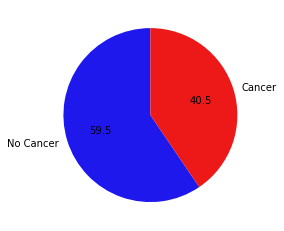

In [9]:
plt.pie(train_data.label.value_counts(), labels=['No Cancer', 'Cancer'], 
        colors=['#1f18ed', '#ed1818'], autopct='%1.1f', startangle=90)
plt.show()

In [10]:
train_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

#### taking a look

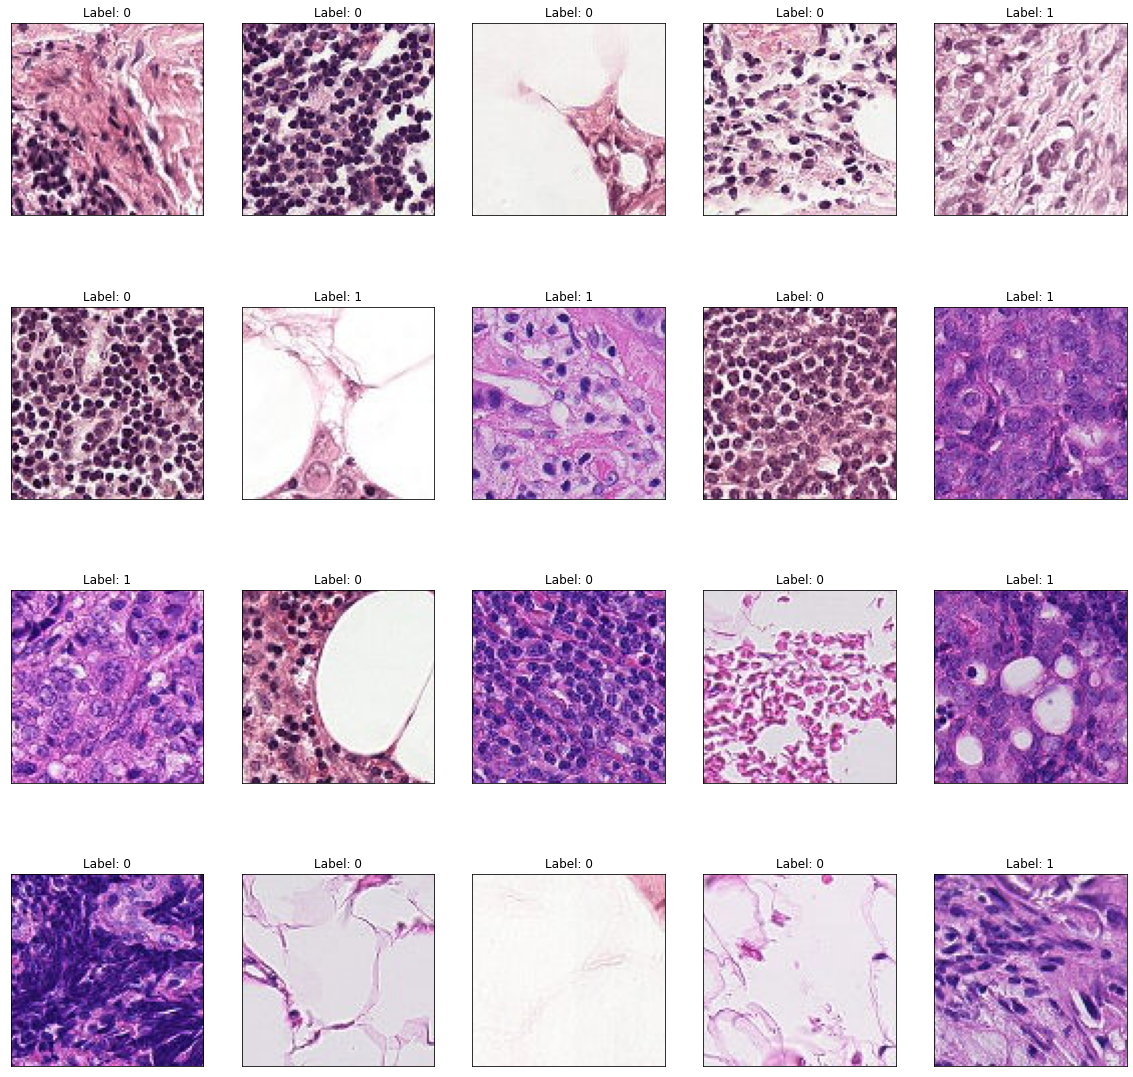

In [11]:
fig = plt.figure(figsize=(20, 20))
train_imgs = os.listdir(path)
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(4, 20//4, idx+1, xticks=[], yticks=[])
    im = Image.open(path + img)
    plt.imshow(im)
    lab = train_data.loc[train_data['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')


#### Splitting the data

In [12]:
train, val = train_test_split(train_data, stratify=train_data.label, test_size=0.1)
len(train), len(val)

(198022, 22003)

#### CNN 


In [13]:
class Dataset(Dataset):
    def __init__(self, data_df, data_dir = './', transform=None):
        super().__init__()
        self.df = data_df.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name + '.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label



In [15]:
batch_size = 64

valid_size = 0.15

In [22]:
trans_train = transforms.Compose([transforms.ToPILImage(),                                              #compose=Convert a tensor or ndarray to a PIL Image object
                                  transforms.Pad(64, padding_mode='reflect'),                           # Add padding so we can perform rotations
                                  transforms.RandomHorizontalFlip(),                                    # Randomly flip left and right
                                  transforms.RandomVerticalFlip(),                                      # Randomly flip upside down
                                  transforms.RandomRotation(20),                                        # Randomly rotate
                                  transforms.ToTensor(),                                                # Move this to a tensor 
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])      # Normalize()

trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

dataset_train = Dataset(data_df=train, data_dir=path, transform=trans_train)
dataset_valid = Dataset(data_df=val, data_dir=path, transform=trans_valid)

train_loader = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)


In [23]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(512 * 1 * 1, 2)
        
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg(x)
        x = x.view(-1, 512 * 1 * 1)
        x = self.fc(x)
        return x

In [24]:
model = CNN().to(device)

In [25]:
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNor

#### Learning algorithm

In [26]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

#### Training 

In [28]:
num_epochs = 5
total_step = len(train_loader)
loss_values = [] 
for epoch in range(num_epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        output = model(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
        
        train_loss = train_loss/len(train_loader.sampler)
        loss_values.append(train_loss / len(dataset_train))
        
        if (i+1) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [50/3095], Loss: 0.5669
Epoch [1/5], Step [100/3095], Loss: 0.4070
Epoch [1/5], Step [150/3095], Loss: 0.5263
Epoch [1/5], Step [200/3095], Loss: 0.3624
Epoch [1/5], Step [250/3095], Loss: 0.3257
Epoch [1/5], Step [300/3095], Loss: 0.4953
Epoch [1/5], Step [350/3095], Loss: 0.5336
Epoch [1/5], Step [400/3095], Loss: 0.4237
Epoch [1/5], Step [450/3095], Loss: 0.4366
Epoch [1/5], Step [500/3095], Loss: 0.3722
Epoch [1/5], Step [550/3095], Loss: 0.3242
Epoch [1/5], Step [600/3095], Loss: 0.5690
Epoch [1/5], Step [650/3095], Loss: 0.3332
Epoch [1/5], Step [700/3095], Loss: 0.3287
Epoch [1/5], Step [750/3095], Loss: 0.3870
Epoch [1/5], Step [800/3095], Loss: 0.2679
Epoch [1/5], Step [850/3095], Loss: 0.3066
Epoch [1/5], Step [900/3095], Loss: 0.4568
Epoch [1/5], Step [950/3095], Loss: 0.1990
Epoch [1/5], Step [1000/3095], Loss: 0.2118
Epoch [1/5], Step [1050/3095], Loss: 0.3353
Epoch [1/5], Step [1100/3095], Loss: 0.3323
Epoch [1/5], Step [1150/3095], Loss: 0.3497
Epoch [1

Epoch [4/5], Step [300/3095], Loss: 0.1638
Epoch [4/5], Step [350/3095], Loss: 0.0793
Epoch [4/5], Step [400/3095], Loss: 0.1122
Epoch [4/5], Step [450/3095], Loss: 0.1324
Epoch [4/5], Step [500/3095], Loss: 0.2743
Epoch [4/5], Step [550/3095], Loss: 0.1124
Epoch [4/5], Step [600/3095], Loss: 0.1257
Epoch [4/5], Step [650/3095], Loss: 0.2044
Epoch [4/5], Step [700/3095], Loss: 0.0940
Epoch [4/5], Step [750/3095], Loss: 0.0818
Epoch [4/5], Step [800/3095], Loss: 0.0881
Epoch [4/5], Step [850/3095], Loss: 0.2359
Epoch [4/5], Step [900/3095], Loss: 0.2002
Epoch [4/5], Step [950/3095], Loss: 0.1952
Epoch [4/5], Step [1000/3095], Loss: 0.1144
Epoch [4/5], Step [1050/3095], Loss: 0.1358
Epoch [4/5], Step [1100/3095], Loss: 0.2356
Epoch [4/5], Step [1150/3095], Loss: 0.1378
Epoch [4/5], Step [1200/3095], Loss: 0.2012
Epoch [4/5], Step [1250/3095], Loss: 0.2083
Epoch [4/5], Step [1300/3095], Loss: 0.2037
Epoch [4/5], Step [1350/3095], Loss: 0.2073
Epoch [4/5], Step [1400/3095], Loss: 0.1076
Ep

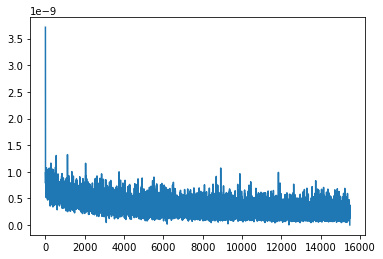

In [29]:
plt.plot(loss_values)

#### eval

In [30]:
model.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

Test Accuracy of the model on the 22003 test images: 95.37335817843021 %


In [31]:
dataset_valid = Dataset(data_df=sub_df, data_dir=test_path, transform=trans_valid)
loader_test = DataLoader(dataset = dataset_valid, batch_size=32, shuffle=False, num_workers=0)

In [32]:
model.eval()

preds = []
for batch_i, (data, target) in enumerate(loader_test):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)

In [33]:

sub_df.shape, len(preds)
sub_df['label'] = preds
sub_df.to_csv("./submission.csv", index=False)



# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')